In [1]:
using Plots
using Distributions
using Random
using Interpolations

# car parameters
mass=1500.0 #kg
power=80e3 #W
brake_acceleration=8.0 #m/s^2
Cd=0.4 # drag coefficient
A=2.0 # frontal area
min_speed=2.5 #m/s
cost_per_J=1.85/(45e6)#$/J
cost_pers_s=40/(60*60)#$/s
red_crossed_penalty=50.0 #$
max_acceleration(v)=min(10.0,power/(v+min_speed)/mass)

rho=1.2 # air density
time_to_green_distribution=Uniform(3,4)#Exponential(3.0)
initial_speed=30.0 #m/s
initial_position=-150.0 #m
location_discretization=400
speed_discretization=50
time_discretization=50
speedup_discretization=1000
acceleration_discretization=30
locations=range(initial_position, stop=0.0, length=location_discretization)
dx=locations[2]-locations[1]
speeds=range(min_speed, stop=initial_speed, length=speed_discretization)
max_time=max(quantile(time_to_green_distribution,0.999))
println("max_time: ", max_time)
times=range(0.0, stop=max_time, length=time_discretization)

accelerations=zeros(location_discretization,time_discretization, speed_discretization)
function compute_power(acceleration::Float64,v)
    drag_force=0.5*rho*Cd*A*v^2
    acceleration_force=max(0,acceleration)*mass
    return (drag_force+acceleration_force)*v
end

loss(time_loss::Real, energy_loss::Real)=time_loss*cost_pers_s+energy_loss*cost_per_J

function compute_speedup_losses()
    x=0.0
    t=0.0
    energy=0.0
    speeds=range(min_speed,stop=initial_speed,length=speedup_discretization)
    energy_loss_speedup=zeros(length(speeds))
    time_loss_speedup=zeros(length(speeds))
    dv=(initial_speed-min_speed)/(speedup_discretization-1)
    for i in eachindex(speeds)
        v=speeds[i]
        a=max_acceleration(v)
        dt=dv/a
        x+=v*dt
        t+=dt
        energy+=compute_power(a,v)*dt
        energy_loss_speedup[i]=energy-compute_power(0.0,initial_speed)/initial_speed*x
        time_loss_speedup[i]=t-x/initial_speed
    end
    final_energy_loss=energy_loss_speedup[end]
    final_time_loss=time_loss_speedup[end]
    energy_loss_speedup=final_energy_loss .- energy_loss_speedup
    time_loss_speedup=final_time_loss .- time_loss_speedup
    loss_speedup=loss.(time_loss_speedup, energy_loss_speedup)
    return Interpolations.LinearInterpolation(speeds, loss_speedup, extrapolation_bc=Flat())
end
speedup_losses=compute_speedup_losses()

dloss(v::Real, a::Real, dt::Real,t)=loss(dt*(initial_speed-v)/initial_speed, compute_power(a,v)*dt)

tail_loss=linear_interpolation((times,speeds),[speedup_losses(v)+red_crossed_penalty for t in times, v in speeds], extrapolation_bc=1000)
tail_losses=[tail_loss]

for i in location_discretization:-1:1
    x=locations[i]
    next_tail_loss_matrix=zeros(time_discretization, speed_discretization)
    for (t_index,t) in enumerate(times)
        for (v_index,v) in enumerate(speeds)
            if cdf(time_to_green_distribution,t) > 0.999
                next_tail_loss_matrix[t_index,v_index]=0.0
                accelerations[i,t_index,v_index]=0.0
                continue
            end
            a = range(-brake_acceleration, stop=max_acceleration(v), length=acceleration_discretization)
            dt=dx/v
            next_v=v .+ a .* dt
            tl=[tail_loss(t+dt,v+a*dt) for a in a]
            @assert all(0.0 .<= tl)
            p_turns_green=(cdf(time_to_green_distribution, t+dt)-cdf(time_to_green_distribution, t)) ./ (1 .- cdf(time_to_green_distribution,t))
            @assert all(1.0 .>= p_turns_green .>= 0) display(p_turns_green)
            time_step_losses=[dloss(v,a,dt,t) for a in a]
            @assert all(0.0 .<= time_step_losses)
            losses=(tl .+ time_step_losses) .* (1 .- p_turns_green) .+ p_turns_green .* speedup_losses(v)
            losses[next_v .< min_speed] .= Inf
            losses[next_v .> initial_speed] .= Inf
            min_loss_index=argmin(losses)
            accelerations[i,t_index,v_index]=a[min_loss_index]
            next_tail_loss_matrix[t_index,v_index]=losses[min_loss_index]
        end
    end
    tail_loss=linear_interpolation((times,speeds),next_tail_loss_matrix, extrapolation_bc=1000)
    pushfirst!(tail_losses,tail_loss)
end

accelerations_interpolation=linear_interpolation((locations,times,speeds),accelerations, extrapolation_bc=0.0)
println("done")


max_time: 3.999
done

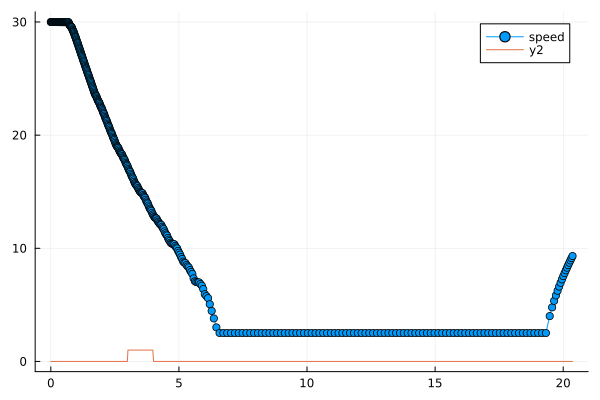

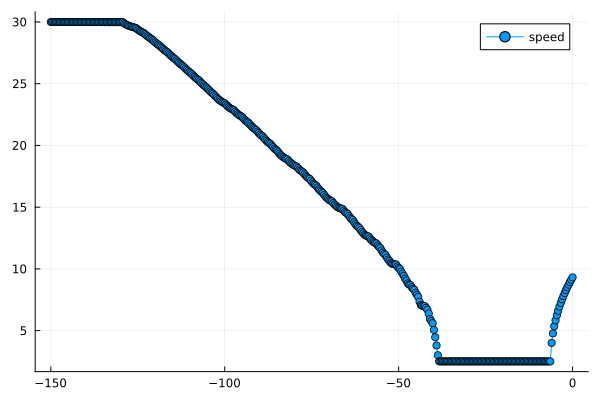

In [2]:
# compute path
function compute_trajectory(initial_speed::Real)
    speeds=zeros(location_discretization)
    times=zeros(location_discretization)
    speeds[1]=initial_speed
    for i in 2:location_discretization
        v=speeds[i-1]
        dt=dx/v
        a=accelerations_interpolation(locations[i],dt,v)
        speeds[i]=v+a*dt
        times[i]=times[i-1]+dt
    end
    return speeds,times
end
v,t=compute_trajectory(initial_speed)
using Plots
plot(t,v, marker=:circle, label="speed")
plot!(t,pdf.(time_to_green_distribution,t)) |> display

plot(locations,v, marker=:circle, label="speed")

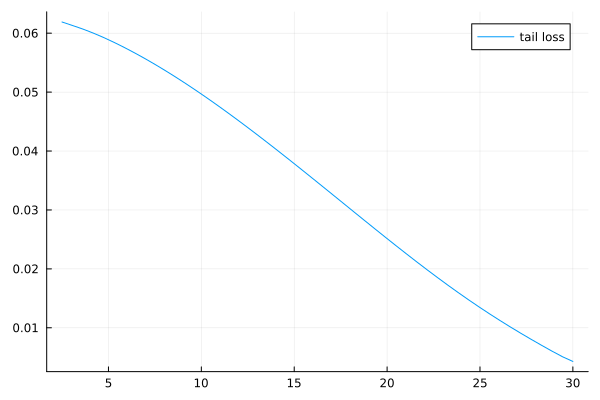

In [3]:
tl=tail_losses[1]
plot(speeds,tl.(0.0,speeds), label="tail loss")